<a href="https://colab.research.google.com/github/Itzmanu2003/Knee_OA/blob/main/main_knee12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Import Libraries
First, we need to import the necessary libraries for data handling, model building, training, and evaluation.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tqdm import tqdm


In [2]:
# prompt: link gdrive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
def load_dataset_as_dataframe(subdir):
    # Define the path to the dataset
    data_dir = f'/content/drive/MyDrive/KneeOA_proj/{subdir}'
    print(f'Load dataset from `{subdir}` subdirectory')

    # Create lists to store image paths and labels
    image_paths = []
    labels = []

    # Get the list of class directories
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    classes.sort()
    print('Classes:', classes)

    # Map class names to labels
    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

    # Loop over each class directory
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        label = class_to_idx[class_name]
        # Get all image files in the class directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(label)

    # Create a DataFrame
    data = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    # Show the distribution of labels in the dataset
    dataset_distribution_dict = {}
    for i in range(5):
        dataset_distribution_dict[i] = len(data[data['label'] == i])
    print(dataset_distribution_dict)
    print()

    return data

In [5]:
# Prepare training and test dataset as dataframes
classes = ['0', '1', '2', '3', '4']
train_df = load_dataset_as_dataframe('train')
test_df = load_dataset_as_dataframe('test')

Load dataset from `train` subdirectory
Classes: ['Doubtful', 'Healthy', 'Minimal', 'Moderate', 'Severe']
{0: 1046, 1: 2286, 2: 1516, 3: 757, 4: 173}

Load dataset from `test` subdirectory
Classes: ['Doubtful', 'Healthy', 'Minimal', 'Moderate', 'Severe']
{0: 296, 1: 639, 2: 447, 3: 223, 4: 51}



In [6]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [7]:
# Create custom dataset class
class KneeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [8]:
# Create dataset instances
train_dataset = KneeDataset(train_df, transform=train_transform)
test_dataset = KneeDataset(test_df, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


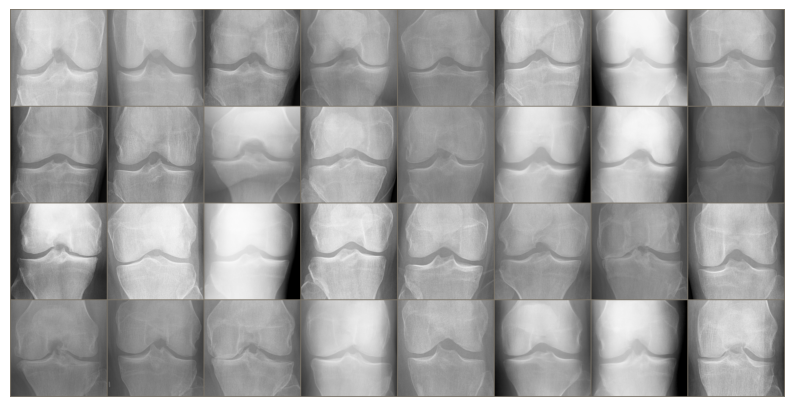

In [9]:
# Function to display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = utils.make_grid(images)

# Display images
plt.figure(figsize=(10, 10))
imshow(out)
plt.show()


In [10]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
num_classes = len(classes)
model.fc = nn.Linear(num_ftrs, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 44.5MB/s]


In [11]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Load pre-trained MobileNetV2
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Modify the final classifier for the number of classes
num_ftrs_mobilenet = mobilenet_v2.last_channel
mobilenet_v2.classifier[1] = nn.Linear(num_ftrs_mobilenet, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 151MB/s]


In [13]:
import torch

class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        # Get predictions from both models
        logits1 = self.model1(x)
        logits2 = self.model2(x)

        # Average the logits (or probabilities) from both models
        avg_logits = (logits1 + logits2) / 2
        return avg_logits

# Initialize the ensemble model
ensemble_model = EnsembleModel(model, mobilenet_v2)


In [14]:
# Number of epochs
num_epochs = 50

# Training loop with progress bars
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Wrap the train_loader with tqdm for a progress bar
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * images.size(0)

        # Calculate accuracy within the batch
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        # Update progress bar description
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(total_correct/total_samples*100):.2f}%'
        })

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = total_correct.double() / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch [1/50]: 100%|██████████| 181/181 [10:31<00:00,  3.49s/it, loss=0.8954, acc=50.62%]


Epoch [1/50], Loss: 1.1728, Accuracy: 0.5062


Epoch [2/50]: 100%|██████████| 181/181 [00:35<00:00,  5.17it/s, loss=0.4280, acc=59.22%]


Epoch [2/50], Loss: 0.9677, Accuracy: 0.5922


Epoch [3/50]: 100%|██████████| 181/181 [00:33<00:00,  5.38it/s, loss=1.0681, acc=62.91%]


Epoch [3/50], Loss: 0.9026, Accuracy: 0.6291


Epoch [4/50]: 100%|██████████| 181/181 [00:33<00:00,  5.38it/s, loss=0.8536, acc=65.32%]


Epoch [4/50], Loss: 0.8366, Accuracy: 0.6532


Epoch [5/50]: 100%|██████████| 181/181 [00:34<00:00,  5.21it/s, loss=0.8816, acc=66.30%]


Epoch [5/50], Loss: 0.8072, Accuracy: 0.6630


Epoch [6/50]: 100%|██████████| 181/181 [00:35<00:00,  5.08it/s, loss=0.9794, acc=66.29%]


Epoch [6/50], Loss: 0.7900, Accuracy: 0.6629


Epoch [7/50]: 100%|██████████| 181/181 [00:33<00:00,  5.38it/s, loss=0.9820, acc=68.64%]


Epoch [7/50], Loss: 0.7578, Accuracy: 0.6864


Epoch [8/50]: 100%|██████████| 181/181 [00:35<00:00,  5.12it/s, loss=0.5802, acc=69.82%]


Epoch [8/50], Loss: 0.7264, Accuracy: 0.6982


Epoch [9/50]: 100%|██████████| 181/181 [00:33<00:00,  5.42it/s, loss=0.4185, acc=70.34%]


Epoch [9/50], Loss: 0.7023, Accuracy: 0.7034


Epoch [10/50]: 100%|██████████| 181/181 [00:36<00:00,  4.99it/s, loss=0.7265, acc=72.20%]


Epoch [10/50], Loss: 0.6775, Accuracy: 0.7220


Epoch [11/50]: 100%|██████████| 181/181 [00:33<00:00,  5.42it/s, loss=0.5988, acc=74.68%]


Epoch [11/50], Loss: 0.6243, Accuracy: 0.7468


Epoch [12/50]: 100%|██████████| 181/181 [00:34<00:00,  5.23it/s, loss=0.7047, acc=75.29%]


Epoch [12/50], Loss: 0.5983, Accuracy: 0.7529


Epoch [13/50]: 100%|██████████| 181/181 [00:33<00:00,  5.41it/s, loss=0.4680, acc=76.55%]


Epoch [13/50], Loss: 0.5656, Accuracy: 0.7655


Epoch [14/50]: 100%|██████████| 181/181 [00:33<00:00,  5.43it/s, loss=0.3902, acc=79.01%]


Epoch [14/50], Loss: 0.5197, Accuracy: 0.7901


Epoch [15/50]: 100%|██████████| 181/181 [00:34<00:00,  5.24it/s, loss=0.5227, acc=80.55%]


Epoch [15/50], Loss: 0.4770, Accuracy: 0.8055


Epoch [16/50]: 100%|██████████| 181/181 [00:34<00:00,  5.22it/s, loss=0.5073, acc=83.45%]


Epoch [16/50], Loss: 0.4244, Accuracy: 0.8345


Epoch [17/50]: 100%|██████████| 181/181 [00:33<00:00,  5.40it/s, loss=0.4008, acc=86.29%]


Epoch [17/50], Loss: 0.3547, Accuracy: 0.8629


Epoch [18/50]: 100%|██████████| 181/181 [00:33<00:00,  5.42it/s, loss=0.2922, acc=86.95%]


Epoch [18/50], Loss: 0.3370, Accuracy: 0.8695


Epoch [19/50]: 100%|██████████| 181/181 [00:33<00:00,  5.43it/s, loss=0.1458, acc=89.29%]


Epoch [19/50], Loss: 0.2790, Accuracy: 0.8929


Epoch [20/50]: 100%|██████████| 181/181 [00:33<00:00,  5.39it/s, loss=0.3549, acc=92.19%]


Epoch [20/50], Loss: 0.2163, Accuracy: 0.9219


Epoch [21/50]: 100%|██████████| 181/181 [00:33<00:00,  5.40it/s, loss=0.0828, acc=91.26%]


Epoch [21/50], Loss: 0.2370, Accuracy: 0.9126


Epoch [22/50]: 100%|██████████| 181/181 [00:34<00:00,  5.32it/s, loss=0.4543, acc=93.63%]


Epoch [22/50], Loss: 0.1735, Accuracy: 0.9363


Epoch [23/50]: 100%|██████████| 181/181 [00:34<00:00,  5.30it/s, loss=0.0665, acc=93.89%]


Epoch [23/50], Loss: 0.1681, Accuracy: 0.9389


Epoch [24/50]: 100%|██████████| 181/181 [00:32<00:00,  5.51it/s, loss=0.2898, acc=94.70%]


Epoch [24/50], Loss: 0.1457, Accuracy: 0.9470


Epoch [25/50]: 100%|██████████| 181/181 [00:33<00:00,  5.40it/s, loss=0.3430, acc=94.79%]


Epoch [25/50], Loss: 0.1426, Accuracy: 0.9479


Epoch [26/50]: 100%|██████████| 181/181 [00:33<00:00,  5.42it/s, loss=0.1039, acc=94.29%]


Epoch [26/50], Loss: 0.1544, Accuracy: 0.9429


Epoch [27/50]: 100%|██████████| 181/181 [00:34<00:00,  5.23it/s, loss=0.0665, acc=96.63%]


Epoch [27/50], Loss: 0.1018, Accuracy: 0.9663


Epoch [28/50]: 100%|██████████| 181/181 [00:34<00:00,  5.18it/s, loss=0.0104, acc=96.59%]


Epoch [28/50], Loss: 0.0954, Accuracy: 0.9659


Epoch [29/50]: 100%|██████████| 181/181 [00:33<00:00,  5.35it/s, loss=0.3594, acc=96.59%]


Epoch [29/50], Loss: 0.0963, Accuracy: 0.9659


Epoch [30/50]: 100%|██████████| 181/181 [00:33<00:00,  5.45it/s, loss=0.4802, acc=96.76%]


Epoch [30/50], Loss: 0.0911, Accuracy: 0.9676


Epoch [31/50]: 100%|██████████| 181/181 [00:33<00:00,  5.45it/s, loss=0.2657, acc=96.02%]


Epoch [31/50], Loss: 0.1038, Accuracy: 0.9602


Epoch [32/50]: 100%|██████████| 181/181 [00:33<00:00,  5.40it/s, loss=0.4375, acc=97.21%]


Epoch [32/50], Loss: 0.0835, Accuracy: 0.9721


Epoch [33/50]: 100%|██████████| 181/181 [00:35<00:00,  5.07it/s, loss=0.0084, acc=96.95%]


Epoch [33/50], Loss: 0.0855, Accuracy: 0.9695


Epoch [34/50]: 100%|██████████| 181/181 [00:34<00:00,  5.28it/s, loss=0.2393, acc=97.75%]


Epoch [34/50], Loss: 0.0658, Accuracy: 0.9775


Epoch [35/50]: 100%|██████████| 181/181 [00:33<00:00,  5.35it/s, loss=0.0149, acc=98.04%]


Epoch [35/50], Loss: 0.0569, Accuracy: 0.9804


Epoch [36/50]: 100%|██████████| 181/181 [00:33<00:00,  5.47it/s, loss=0.2272, acc=97.47%]


Epoch [36/50], Loss: 0.0734, Accuracy: 0.9747


Epoch [37/50]: 100%|██████████| 181/181 [00:33<00:00,  5.36it/s, loss=0.3165, acc=97.08%]


Epoch [37/50], Loss: 0.0856, Accuracy: 0.9708


Epoch [38/50]: 100%|██████████| 181/181 [00:34<00:00,  5.31it/s, loss=0.1444, acc=96.95%]


Epoch [38/50], Loss: 0.0860, Accuracy: 0.9695


Epoch [39/50]: 100%|██████████| 181/181 [00:35<00:00,  5.12it/s, loss=0.0451, acc=97.75%]


Epoch [39/50], Loss: 0.0651, Accuracy: 0.9775


Epoch [40/50]: 100%|██████████| 181/181 [00:33<00:00,  5.33it/s, loss=0.2059, acc=97.11%]


Epoch [40/50], Loss: 0.0843, Accuracy: 0.9711


Epoch [41/50]: 100%|██████████| 181/181 [00:35<00:00,  5.11it/s, loss=0.1928, acc=98.25%]


Epoch [41/50], Loss: 0.0512, Accuracy: 0.9825


Epoch [42/50]: 100%|██████████| 181/181 [00:33<00:00,  5.41it/s, loss=0.2679, acc=98.18%]


Epoch [42/50], Loss: 0.0508, Accuracy: 0.9818


Epoch [43/50]: 100%|██████████| 181/181 [00:33<00:00,  5.34it/s, loss=0.0004, acc=98.34%]


Epoch [43/50], Loss: 0.0458, Accuracy: 0.9834


Epoch [44/50]: 100%|██████████| 181/181 [00:34<00:00,  5.21it/s, loss=0.1039, acc=98.34%]


Epoch [44/50], Loss: 0.0465, Accuracy: 0.9834


Epoch [45/50]: 100%|██████████| 181/181 [00:33<00:00,  5.47it/s, loss=0.0417, acc=98.30%]


Epoch [45/50], Loss: 0.0485, Accuracy: 0.9830


Epoch [46/50]: 100%|██████████| 181/181 [00:33<00:00,  5.42it/s, loss=0.1933, acc=97.99%]


Epoch [46/50], Loss: 0.0581, Accuracy: 0.9799


Epoch [47/50]: 100%|██████████| 181/181 [00:33<00:00,  5.43it/s, loss=0.1416, acc=97.66%]


Epoch [47/50], Loss: 0.0732, Accuracy: 0.9766


Epoch [48/50]: 100%|██████████| 181/181 [00:33<00:00,  5.36it/s, loss=0.0327, acc=97.42%]


Epoch [48/50], Loss: 0.0702, Accuracy: 0.9742


Epoch [49/50]: 100%|██████████| 181/181 [00:35<00:00,  5.12it/s, loss=0.0058, acc=98.15%]


Epoch [49/50], Loss: 0.0525, Accuracy: 0.9815


Epoch [50/50]: 100%|██████████| 181/181 [00:35<00:00,  5.09it/s, loss=0.0035, acc=98.60%]

Epoch [50/50], Loss: 0.0413, Accuracy: 0.9860


In [15]:
# prompt: save above model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
from google.colab import drive



# ... (rest of the code from the previous response)

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/knee_oa_model.pth')

Accuracy on test set: 0.6153
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.23      0.26       296
           1       0.71      0.71      0.71       639
           2       0.58      0.67      0.62       447
           3       0.70      0.75      0.73       223
           4       0.91      0.63      0.74        51

    accuracy                           0.62      1656
   macro avg       0.64      0.60      0.61      1656
weighted avg       0.61      0.62      0.61      1656

Confusion Matrix:
[[ 69 130  92   5   0]
 [100 452  83   4   0]
 [ 52  51 298  46   0]
 [  8   1  43 168   3]
 [  0   0   2  17  32]]


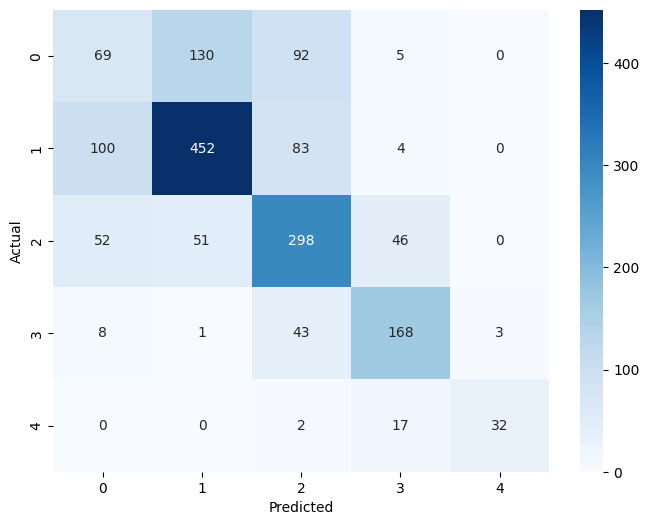

In [16]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test set: {accuracy:.4f}')

# Classification report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


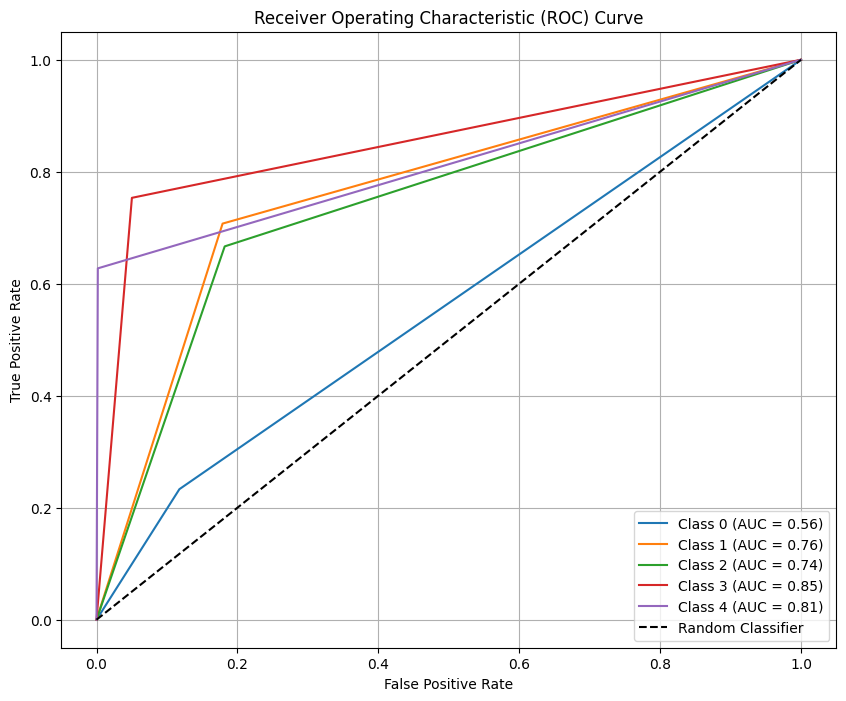

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assume `classes` contains the class names (e.g., ['class0', 'class1', ...])
n_classes = len(classes)

# Binarize the labels for ROC curve (one-vs-rest approach)
all_labels_binarized = label_binarize(all_labels, classes=range(n_classes))
all_preds_binarized = label_binarize(all_preds, classes=range(n_classes))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_preds_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()
